In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

First, we load the required libraries:

In [2]:
# Specify the path to the project directory
PROJECT_PATH = '/Users/kunal/Desktop/MSAN_Coursework/621_ML/fastai/fastai'   # Update this
!cd {PROJECT_PATH}
# Create sym-link to the fastai library
!ln -s {PROJECT_PATH} ./

ln: .//fastai: File exists


In [3]:
import sys
sys.path.append('/Users/anantagarwal/Desktop/Module2/Machine_Learning/fastai/')

In [4]:
from fastai.imports import *
from fastai.structured import *

from pandas_summary import DataFrameSummary
from sklearn.ensemble import RandomForestRegressor
from IPython.display import display

from sklearn import metrics

from dateutil.relativedelta import relativedelta

In [5]:
PATH = "~/data/grocery_sales"      # path to the data directory

## What Does Our Data Look Like?
Let's load the data from the files provided for the competition and take a look at it.

### Training Data
The training data, `train.csv` is a large file (~5 GB).  On a machine with relatively low RAM (e.g. 8 GB), attempting to load the entire file in a pandas DataFrame can lead to failure caused by running out of memory.  One way of fixing this issue is to make use of the `low_memory=True` argument of `read_csv`.  With this method, the csv file is processed in chunks requiring lower memory usage, while at the same time reading the csv's contents into a single DataFrame.

However, the dtypes of the columns of the DataFrame must be specified in `read_csv` if we wish to set `low_memory=True`.  This is because not specifying dtypes forces pandas to guess column dtypes - which is a memory-intensive task.  Please see this Stack Overflow answer for a additional explanation:
https://stackoverflow.com/a/27232309


We first create a new file called `small_train.csv` using only the first row of data from `train.csv`:

In [11]:
!head -2 {PATH}/train.csv > {PATH}/small_train.csv

In [12]:
PATH + '/small_train.csv'

'~/data/grocery_sales/small_train.csv'

In [13]:
small_train = pd.read_csv(PATH + '/small_train.csv')

In [14]:
print(small_train)

   id        date  store_nbr  item_nbr  unit_sales  onpromotion
0   0  2013-01-01         25    103665         7.0          NaN


In [15]:
types_dict = small_train.dtypes.to_dict()

In [16]:
types_dict

{'date': dtype('O'),
 'id': dtype('int64'),
 'item_nbr': dtype('int64'),
 'onpromotion': dtype('float64'),
 'store_nbr': dtype('int64'),
 'unit_sales': dtype('float64')}

In [17]:
# Update types of some columns to make them more memory efficient.  This is based on information shared in kernels
# by other people
types_dict = {'id': 'int32',
             'item_nbr': 'int32',
             'store_nbr': 'int8',
             'unit_sales': 'float32'}

Now, we can use `types_dict` to specify the dtypes of each column of the DataFrame we are loading the `train.csv` file into:

In [7]:
grocery_train = pd.read_csv(PATH + '/train.csv', low_memory=True, dtype=types_dict)

/Users/anantagarwal/anaconda/envs/fastai/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2698: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [8]:
grocery_train.shape  # (No. of observations, No. of features)

(125497040, 6)

Next, we convert the `date` column to dtype `datetime` and add columns showing the `year`, `month`, and `day`.

In [9]:
# We'll use add_datepart, so this section is not needed
grocery_train['date'] =  pd.to_datetime(grocery_train['date'])
# grocery_train['year'] = grocery_train['date'].dt.year
# grocery_train['month'] = grocery_train['date'].dt.month
# grocery_train['day'] = grocery_train['date'].dt.day
# grocery_train.drop('date', axis=1, inplace=True)

In [10]:
grocery_train.head()

,id,date,store_nbr,item_nbr,unit_sales,onpromotion
0,0,2013-01-01,25,103665,7.0,NaN
1,1,2013-01-01,25,105574,1.0,NaN
2,2,2013-01-01,25,105575,2.0,NaN
3,3,2013-01-01,25,108079,1.0,NaN
4,4,2013-01-01,25,108701,1.0,NaN


Looks like the `onpromotion` column was not converted to `bool` - that’s because there are missing values, and Pandas does not want missing values in `bool` type columns.

In [11]:
grocery_train.dtypes

id                      int32
date           datetime64[ns]
store_nbr                int8
item_nbr                int32
unit_sales            float32
onpromotion            object
dtype: object

#### Dealing with `onpromotion` Missing Values
First, we want to change the data type in the `onpromotion` column to an integer (because later we will set missing values to `-1`) - hence, we convert `FALSE` to `0` and `TRUE` to `1`.  Next, let's replace all missing values in `onpromotion` with `-1`.

In [12]:
grocery_train.onpromotion = grocery_train.onpromotion.map({False : 0, True : 1})

# Note for Anant - let's not create this new promo_missing column yet
# grocery_train['promo_missing'] = np.where(grocery_train['onpromotion'] == -1, 1, 0)

In [13]:
grocery_train['onpromotion'].fillna(-1, inplace=True)
grocery_train.head()

,id,date,store_nbr,item_nbr,unit_sales,onpromotion
0,0,2013-01-01,25,103665,7.0,-1.0
1,1,2013-01-01,25,105574,1.0,-1.0
2,2,2013-01-01,25,105575,2.0,-1.0
3,3,2013-01-01,25,108079,1.0,-1.0
4,4,2013-01-01,25,108701,1.0,-1.0


In [14]:
grocery_train.tail()

,id,date,store_nbr,item_nbr,unit_sales,onpromotion
125497035,125497035,2017-08-15,54,2089339,4.0,0.0
125497036,125497036,2017-08-15,54,2106464,1.0,1.0
125497037,125497037,2017-08-15,54,2110456,192.0,0.0
125497038,125497038,2017-08-15,54,2113914,198.0,1.0
125497039,125497039,2017-08-15,54,2116416,2.0,0.0


In [15]:
grocery_train.dtypes

id                      int32
date           datetime64[ns]
store_nbr                int8
item_nbr                int32
unit_sales            float32
onpromotion           float64
dtype: object

In [16]:
# Update types of some columns to make them more memory efficient.  This is based on information shared in kernels
# by other people
grocery_train.onpromotion = grocery_train.onpromotion.astype('int8')
grocery_train.unit_sales = grocery_train.unit_sales.astype('float32')   # note that float16 is not supported by feather
grocery_train.dtypes

id                      int32
date           datetime64[ns]
store_nbr                int8
item_nbr                int32
unit_sales            float32
onpromotion              int8
dtype: object

At this point we can save `grocery_train` in the feather format for faster subsequent access.

In [17]:
os.makedirs('tmp', exist_ok=True)       # Make a tmp directory for storing the feather format dataframe
grocery_train.to_feather('./tmp/grocery_train_raw')

In [22]:
grocery_train.shape

(125497040, 6)

### Going forward, we can read the `grocery_train` dataframe directly from the feather file as shown below:

In [5]:
grocery_train = pd.read_feather('./tmp/train_sub_raw')

In [6]:
grocery_train.head()

NameError: name 'grocery_train' is not defined

## Slicing a Subset of Data from `train.csv` to Train the Model

In [6]:
def subset_training_by_time(grocery_train, num_months):
    last_dt_train = grocery_train.date.max() # Last date available in the training set (train.csv)
    # First date of the subset of the training data (1 year prior to test set start)
    train_sub_startdt = last_dt_train - relativedelta(months = num_months)
    # Sort training data before slicing it based on dates
    grocery_train.sort_values('date', ascending=True, inplace=True)
    # We extract data that starts num_months prior to the start of test data
    subset_index = sorted(grocery_train.index[grocery_train['date'] == train_sub_startdt].tolist())[0]
    train_sub = grocery_train[subset_index: ].copy()
    return train_sub

In [7]:
# Extract subset of training data - to use as superset for random forest
train_sub = subset_training_by_time(grocery_train, num_months=12)
# This is the data 12 months prior to the test date start

In [8]:
train_sub.head()
train_sub.shape

(3359566, 23)

In every sale recorded in the training data, a negative value of `unit_sales` represents a returned item.  Using this, we can add a column indicating whether an item was returned or not: 

In [9]:
train_sub['was_returned'] = np.where(train_sub['unit_sales'] < 0, 1, 0)
train_sub.was_returned = train_sub.was_returned.astype('int8')

In [10]:
train_sub.head()
# grocery_train_rand.dtypes

,id,date,store_nbr,item_nbr,unit_sales,onpromotion,was_returned,transactions,city,state,...,class,perishable,item_score_wt,dcoilwtico,holiday_type_city,description_city,holiday_type_state,description_state,holiday_type_nat,description_nat
34169327,122137488,2017-07-15,1,112830,5.0,0,0,1338.0,Quito,Pichincha,...,1044,0,1.0,46.630527,no holiday,no holiday,no holiday,no holiday,no holiday,no holiday
34169341,122137474,2017-07-15,1,99197,2.0,0,0,1338.0,Quito,Pichincha,...,1067,0,1.0,46.630527,no holiday,no holiday,no holiday,no holiday,no holiday,no holiday
34169340,122137475,2017-07-15,1,103520,1.0,0,0,1338.0,Quito,Pichincha,...,1028,0,1.0,46.630527,no holiday,no holiday,no holiday,no holiday,no holiday,no holiday
34169324,122137491,2017-07-15,1,114799,2.0,0,0,1338.0,Quito,Pichincha,...,4126,0,1.0,46.630527,no holiday,no holiday,no holiday,no holiday,no holiday,no holiday
34169339,122137476,2017-07-15,1,105574,6.0,0,0,1338.0,Quito,Pichincha,...,1045,0,1.0,46.630527,no holiday,no holiday,no holiday,no holiday,no holiday,no holiday


### Stores Data

In [11]:
stores = pd.read_csv(PATH + '/stores.csv')
stores.shape # (No. of observations, No. of features)

(54, 5)

In [12]:
# stores.dtypes
stores.head()

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


### Items Data

In [13]:
items = pd.read_csv(PATH + '/items.csv')
items.shape # (No. of observations, No. of features)

(4100, 4)

### Transactions Data

In [34]:
transactions = pd.read_csv(PATH + '/transactions.csv')
transactions['date'] =  pd.to_datetime(transactions['date'])
# transactions = transactions.set_index('date')
# transactions['year'] = transactions['date'].dt.year
# transactions['month'] = transactions['date'].dt.month
# transactions['day'] = transactions['date'].dt.day
# transactions.drop('date', axis=1, inplace=True)
transactions.shape # (No. of observations, No. of features)

(83488, 3)

In [35]:
transactions.head()

,date,store_nbr,transactions
0,2013-01-01,25,770
1,2013-01-02,1,2111
2,2013-01-02,2,2358
3,2013-01-02,3,3487
4,2013-01-02,4,1922


### Oil Data

In [16]:
oil = pd.read_csv(PATH + '/oil.csv')
oil.head()

,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-07,93.20


In [17]:
oil['date'] =  pd.to_datetime(oil['date'])
# oil['year'] = oil['date'].dt.year
# oil['month'] = oil['date'].dt.month
# oil['day'] = oil['date'].dt.day

In [18]:
# oil.drop('date', axis=1, inplace=True)
oil.shape # (No. of observations, No. of features)
oil.dropna(inplace=True)  # Drop all rows with missing values (43 rows dropped)

In [19]:
oil.dcoilwtico = oil.dcoilwtico.astype('float32')
oil.head(1)

,date,dcoilwtico
1,2013-01-02,93.139999


In [20]:
oil['date'].max()

Timestamp('2017-08-31 00:00:00')

In [21]:
transactions['date'].max()

Timestamp('2017-08-15 00:00:00')

In [22]:
len(oil)

1175

### Holidays Data

In [23]:
holidays = pd.read_csv(PATH + '/holidays_events.csv')
holidays['date'] =  pd.to_datetime(holidays['date'])
# holidays['year'] = holidays['date'].dt.year
# holidays['month'] = holidays['date'].dt.month
# holidays['day'] = holidays['date'].dt.day
holidays.shape # (No. of observations, No. of features)

(350, 6)

In [24]:
holidays['date'].max()

Timestamp('2017-12-26 00:00:00')

In [25]:
holidays.type.unique()
# holidays.locale.unique()

array(['Holiday', 'Transfer', 'Additional', 'Bridge', 'Work Day', 'Event'], dtype=object)

In [26]:
# We are only interested in holidays - we will remove everything else
# holidays.drop(holidays[holidays.type == 'Work Day'].index, inplace=True)
# When transferred = True, that was not a holiday; it was a regular workday, so remove it
holidays.drop(holidays[holidays.transferred == True].index, inplace=True)
# Every other entry in the holidays dataframe corresponds to an actual holiday 
# or a 'sales-holiday event' (e.g. black friday)

In [27]:
holidays.columns[holidays.isnull().any()]   # these columns have missing values

Index([], dtype='object')

In [28]:
# Assume national holidays take precendence over regional and local holidays and delete non-national holidays 
# that fall on the same day

# dates_national_holidays = holidays.date[holidays.locale == "National"]
# holidays.drop(holidays[holidays['date'].isin(dates_national_holidays) & holidays.locale != 'National'])

# holidays.drop(holidays[holidays.transferred == True].index, inplace=True)

# holidays[holidays.locale == 'National'].locale = 'A'
# holidays.loc[holidays.locale == "National"] = "A"
# holidays

In [29]:
# Temporarily map 'National' to 'A' and sort by locale, 
# so national holidays are at the top in cases where the same date has multiple holidays
# holidays.locale = holidays.locale.map({'National' : 'A', 'Regional' : 'Regional', 'Local' : 'Local'})
# holidays.sort_values('locale', ascending=True)
# holidays.drop_duplicates(subset=['date'], keep='first', inplace=True)  # Drop duplicated dates, retaining national holidays
# holidays.locale = holidays.locale.map({'A' : 'National', 'Regional' : 'Regional', 'Local' : 'Local'})
# holidays.drop('date', axis=1, inplace=True)

In [30]:
holidays.head(1)

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False


In [31]:
# Break holidays into separate dataframes
holidays_cities = holidays[holidays.locale == "Local"]       # city level holidays
holidays_states = holidays[holidays.locale == "Regional"]    # state level holidays
holidays_national = holidays[holidays.locale == "National"]  # national holidays

# Rename columns to help with joining dataframes later
holidays_cities = holidays_cities.rename(columns = {'locale_name':'city', 'type':'holiday_type'})
holidays_states = holidays_states.rename(columns = {'locale_name':'state', 'type':'holiday_type'})
holidays_national = holidays_national.rename(columns = {'type':'holiday_type'})

# We don't need locale_name at all for national holidays
holidays_national.drop('locale_name', axis=1, inplace=True)

# locale column is useless - let's drop it to simplify joining dataframes
holidays_cities.drop('locale', axis=1, inplace=True)
holidays_states.drop('locale', axis=1, inplace=True)
holidays_national.drop('locale', axis=1, inplace=True)

# transferred column is now useless - let's drop it to simplify joining dataframes
holidays_cities.drop('transferred', axis=1, inplace=True)
holidays_states.drop('transferred', axis=1, inplace=True)
holidays_national.drop('transferred', axis=1, inplace=True)
# holidays_cities.head()
# holiday_cities = set(list((holidays.locale_name[holidays.locale == "Local"]).unique()))

In [32]:
holidays_cities.head(1)

,date,holiday_type,city,description
0,2012-03-02,Holiday,Manta,Fundacion de Manta


In [33]:
holidays_states.head(1)

,date,holiday_type,state,description
1,2012-04-01,Holiday,Cotopaxi,Provincializacion de Cotopaxi


In [34]:
holidays_national.head(1)

,date,holiday_type,description
14,2012-08-10,Holiday,Primer Grito de Independencia


In [109]:
train_sub.head(1)

,id,date,store_nbr,item_nbr,unit_sales,onpromotion,was_returned
88042205,88042205,2016-08-15,1,103665,1.0,0,0


In [110]:
stores.head(1)

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13


In [111]:
transactions.head(1)

,date,store_nbr,transactions
0,2013-01-01,25,770


In [112]:
items.head(1)

,item_nbr,family,class,perishable
0,96995,GROCERY I,1093,0


In [113]:
oil.head()

,date,dcoilwtico
1,2013-01-02,93.139999
2,2013-01-03,92.970001
3,2013-01-04,93.120003
4,2013-01-07,93.199997
5,2013-01-08,93.209999


### Creating a Single DataFrame for the Training Data

In [35]:
train_sub = pd.merge(train_sub, transactions, how='left', on=['store_nbr', 'date'])
train_sub.columns[train_sub.isnull().any()]   # these columns have missing values
# Note: transactions has missing values implies that possibly some stores present in grocery_train_rand are absent in transactions

Index([], dtype='object')

In [36]:
store_train = set(train_sub.store_nbr.unique())
store_trans = set(transactions.store_nbr.unique())
store_train - store_trans
# The result shows that there is no issue with stores.  That means there must be some dates which are not recorded in
# the transactions dataframe

set()

In [37]:
transactions.head(1)

,date,store_nbr,transactions
0,2013-01-01,25,770


In [38]:
# transactions_median = transactions.groupby(['store_nbr', 'year', 'month'], as_index=False)[['transactions']].median()
transactions['year'] = transactions['date'].dt.year
transactions['month'] = transactions['date'].dt.month
transactions_median = transactions.groupby(['store_nbr', 'year', 'month'], as_index=False).median()
transactions_median = transactions_median.rename(columns = {'transactions':'transactions_median'})
transactions_median.head(1)

,store_nbr,year,month,transactions_median
0,1,2013,1,1766.0


In [39]:
transactions.drop(['year', 'month'], axis=1, inplace=True)

In [40]:
transactions_median.head(1)

,store_nbr,year,month,transactions_median
0,1,2013,1,1766.0


In [42]:
train_sub.head(1).dtypes

id                              int32
date                   datetime64[ns]
store_nbr                        int8
item_nbr                        int32
unit_sales                    float32
onpromotion                      int8
was_returned                     int8
transactions_x                float64
city                           object
state                          object
type                           object
cluster                         int64
family                         object
class                           int64
perishable                      int64
item_score_wt                 float64
dcoilwtico                    float32
holiday_type_city              object
description_city               object
holiday_type_state             object
description_state              object
holiday_type_nat               object
description_nat                object
transactions_y                  int64
year                            int64
month                           int64
transactions

In [41]:
# Replace missing transactions with median transactions imputed above
train_sub['year'] = train_sub['date'].dt.year
train_sub['month'] = train_sub['date'].dt.month
train_sub = pd.merge(train_sub, transactions_median, how='left', on=['store_nbr', 'year', 'month'])
train_sub['transactions'].fillna(train_sub['transactions_median'], inplace=True)
train_sub.drop('transactions_median', axis=1, inplace=True)
train_sub.columns[train_sub.isnull().any()]   # these columns have missing values
train_sub.drop(['year', 'month'], axis=1, inplace=True)

KeyError: 'transactions'

In [ ]:
train_sub = pd.merge(train_sub, stores, how='left', on='store_nbr')
train_sub.columns[train_sub.isnull().any()]   # these columns have missing values

In [122]:
train_sub = pd.merge(train_sub, items, how='left', on='item_nbr')
train_sub.columns[train_sub.isnull().any()]   # these columns have missing values

Index([], dtype='object')

In [123]:
train_sub = pd.merge(train_sub, oil, how='left', on=['date'])
train_sub.columns[train_sub.isnull().any()]   # these columns have missing values

Index(['dcoilwtico'], dtype='object')

In [124]:
# there are missing values in dcoilwtico (oil price).  Let's imputed it using average for the month-year combo
train_sub['year'] = train_sub['date'].dt.year
train_sub['month'] = train_sub['date'].dt.month

oil['year'] = oil['date'].dt.year
oil['month'] = oil['date'].dt.month

dcoilwtico_mean = oil.groupby(['year', 'month'], as_index=False)[['dcoilwtico']].mean()
dcoilwtico_mean = dcoilwtico_mean.rename(columns = {'dcoilwtico':'dcoilwtico_mean'})
dcoilwtico_mean.head(1)

,year,month,dcoilwtico_mean
0,2013,1,94.756668


In [125]:
# Replace missing dcoilwtico (oil price) with average dcoilwtico imputed above
train_sub = pd.merge(train_sub, dcoilwtico_mean, how='left', on=['year', 'month'])
train_sub['dcoilwtico'].fillna(train_sub['dcoilwtico_mean'], inplace=True)
train_sub.drop('dcoilwtico_mean', axis=1, inplace=True)
train_sub.drop(['year', 'month'], axis=1, inplace=True)
oil.drop(['year', 'month'], axis=1, inplace=True)

In [126]:
train_sub.columns[train_sub.isnull().any()]   # these columns have missing values

Index([], dtype='object')

In [127]:
train_sub = pd.merge(train_sub, holidays_cities, how='left', on=['date', 'city'])
train_sub.columns[train_sub.isnull().any()]   # these columns have missing values

Index(['holiday_type', 'description'], dtype='object')

In [128]:
train_sub = train_sub.rename(columns = {'holiday_type':'holiday_type_city', 'description':'description_city'})

In [129]:
train_sub = pd.merge(train_sub, holidays_states, how='left', on=['date', 'state'])
train_sub.columns[train_sub.isnull().any()]   # these columns have missing values

Index(['holiday_type_city', 'description_city', 'holiday_type', 'description'], dtype='object')

In [130]:
train_sub = train_sub.rename(columns = {'holiday_type':'holiday_type_state', 'description':'description_state'})

In [131]:
train_sub = pd.merge(train_sub, holidays_national, how='left', on=['date'])
train_sub.columns[train_sub.isnull().any()]   # these columns have missing values

Index(['holiday_type_city', 'description_city', 'holiday_type_state',
       'description_state', 'holiday_type', 'description'],
      dtype='object')

In [132]:
train_sub.rename(columns = {'holiday_type':'holiday_type_nat', 'description':'description_nat'}, inplace=True)

In [133]:
train_sub.dtypes

id                             int32
date                  datetime64[ns]
store_nbr                       int8
item_nbr                       int32
unit_sales                   float32
onpromotion                     int8
was_returned                    int8
transactions                 float64
city                          object
state                         object
type                          object
cluster                        int64
family                        object
class                          int64
perishable                     int64
dcoilwtico                   float32
holiday_type_city             object
description_city              object
holiday_type_state            object
description_state             object
holiday_type_nat              object
description_nat               object
dtype: object

In [134]:
# Impute missing values
train_sub['holiday_type_city'].fillna('no holiday', inplace=True)
train_sub['holiday_type_state'].fillna('no holiday', inplace=True)
train_sub['holiday_type_nat'].fillna('no holiday', inplace=True)
train_sub['description_city'].fillna('no holiday', inplace=True)
train_sub['description_state'].fillna('no holiday', inplace=True)
train_sub['description_nat'].fillna('no holiday', inplace=True)

# train_sub.drop('holiday_type_state', axis=1, inplace=True)
# train_sub['holiday_type_city'].fillna(train_sub['holiday_type_nat'], inplace=True)
# train_sub.drop('holiday_type_nat', axis=1, inplace=True)

In [136]:
train_sub.dtypes

id                             int32
date                  datetime64[ns]
store_nbr                       int8
item_nbr                       int32
unit_sales                   float32
onpromotion                     int8
was_returned                    int8
transactions                 float64
city                          object
state                         object
type                          object
cluster                        int64
family                        object
class                          int64
perishable                     int64
dcoilwtico                   float32
holiday_type_city             object
description_city              object
holiday_type_state            object
description_state             object
holiday_type_nat              object
description_nat               object
dtype: object

In [137]:
train_sub.columns[train_sub.isnull().any()]   # these columns have missing values

Index([], dtype='object')

In [138]:
train_sub.shape   # dims of the merged dataframe at this point

(37454835, 22)

In [139]:
train_sub.head()

,id,date,store_nbr,item_nbr,unit_sales,onpromotion,was_returned,transactions,city,state,...,family,class,perishable,dcoilwtico,holiday_type_city,description_city,holiday_type_state,description_state,holiday_type_nat,description_nat
0,88042205,2016-08-15,1,103665,1.0,0,0,1776.0,Quito,Pichincha,...,BREAD/BAKERY,2712,1,45.720001,no holiday,no holiday,no holiday,no holiday,no holiday,no holiday
1,88042206,2016-08-15,1,105574,1.0,0,0,1776.0,Quito,Pichincha,...,GROCERY I,1045,0,45.720001,no holiday,no holiday,no holiday,no holiday,no holiday,no holiday
2,88042207,2016-08-15,1,105575,19.0,0,0,1776.0,Quito,Pichincha,...,GROCERY I,1045,0,45.720001,no holiday,no holiday,no holiday,no holiday,no holiday,no holiday
3,88042208,2016-08-15,1,105577,1.0,0,0,1776.0,Quito,Pichincha,...,GROCERY I,1045,0,45.720001,no holiday,no holiday,no holiday,no holiday,no holiday,no holiday
4,88042209,2016-08-15,1,105693,1.0,0,0,1776.0,Quito,Pichincha,...,GROCERY I,1034,0,45.720001,no holiday,no holiday,no holiday,no holiday,no holiday,no holiday


In [140]:
# Save the merged dataframe at this point
train_sub.to_feather('./tmp/train_sub_raw')

### Going forward, we can read the `train_sub` dataframe directly from the feather file as shown below:

In [9]:
train_sub = pd.read_feather('./tmp/train_sub_raw')

In [11]:
train_sub.head()

,id,date,store_nbr,item_nbr,unit_sales,onpromotion,was_returned,transactions,city,state,...,Week,Day,Dayofweek,Dayofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start
0,88042205,2016-08-15,1,103665,1.0,0,0,1776.0,Quito,Pichincha,...,33,15,0,228,False,False,False,False,False,False
1,88042206,2016-08-15,1,105574,1.0,0,0,1776.0,Quito,Pichincha,...,33,15,0,228,False,False,False,False,False,False
2,88042207,2016-08-15,1,105575,19.0,0,0,1776.0,Quito,Pichincha,...,33,15,0,228,False,False,False,False,False,False
3,88042208,2016-08-15,1,105577,1.0,0,0,1776.0,Quito,Pichincha,...,33,15,0,228,False,False,False,False,False,False
4,88042209,2016-08-15,1,105693,1.0,0,0,1776.0,Quito,Pichincha,...,33,15,0,228,False,False,False,False,False,False


In [10]:
# Add supplemental date information
add_datepart(train_sub, 'date')

KeyboardInterrupt: 

In [81]:
train_cats(train_sub)   # call train_cats to convert strings to pandas categories.

In [82]:
train_sub.shape

(102812, 34)

In [83]:
train_sub.dtypes

id                       int32
store_nbr                 int8
item_nbr                 int32
unit_sales             float32
onpromotion               int8
was_returned              int8
transactions             int64
city                  category
state                 category
type                  category
cluster                  int64
family                category
class                    int64
perishable               int64
dcoilwtico             float32
holiday_type_city     category
description_city      category
holiday_type_state    category
description_state     category
holiday_type_nat      category
description_nat       category
Year                     int64
Month                    int64
Week                     int64
Day                      int64
Dayofweek                int64
Dayofyear                int64
Is_month_end              bool
Is_month_start            bool
Is_quarter_end            bool
Is_quarter_start          bool
Is_year_end               bool
Is_year_

In [75]:
train_sub.head()

,id,store_nbr,item_nbr,unit_sales,onpromotion,was_returned,transactions,city,state,type,...,Day,Dayofweek,Dayofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start,Elapsed
0,88106511,38,1998889,2.0,0,0,1301.0,Loja,Loja,D,...,15,0,228,False,False,False,False,False,False,1471219200
1,88106510,38,1998005,4.0,0,0,1301.0,Loja,Loja,D,...,15,0,228,False,False,False,False,False,False,1471219200
2,88106509,38,1997976,1.0,0,0,1301.0,Loja,Loja,D,...,15,0,228,False,False,False,False,False,False,1471219200
3,88106508,38,1997895,1.0,0,0,1301.0,Loja,Loja,D,...,15,0,228,False,False,False,False,False,False,1471219200
4,88106507,38,1994863,9.0,0,0,1301.0,Loja,Loja,D,...,15,0,228,False,False,False,False,False,False,1471219200


In [76]:
# Save the updated dataframe at this point
train_sub.to_feather('./tmp/train_sub_raw_02')

In [5]:
# Load feather file:
train_sub = pd.read_feather('./tmp/train_sub_raw_02')

In [6]:
# Drop item_score_wt because it is entirely dependent on the perishable column
train_sub.drop('item_score_wt', axis=1, inplace=True)

ValueError: labels ['item_score_wt'] not contained in axis

In [6]:
train_sub.shape

(37454835, 34)

In [11]:
# Overwrite previous feather file
train_sub.to_feather('./tmp/train_sub_raw_02')

In [8]:
list(train_sub.head(1).columns.values)

['id',
 'store_nbr',
 'item_nbr',
 'unit_sales',
 'onpromotion',
 'was_returned',
 'transactions',
 'city',
 'state',
 'type',
 'cluster',
 'family',
 'class',
 'perishable',
 'dcoilwtico',
 'holiday_type_city',
 'description_city',
 'holiday_type_state',
 'description_state',
 'holiday_type_nat',
 'description_nat',
 'Year',
 'Month',
 'Week',
 'Day',
 'Dayofweek',
 'Dayofyear',
 'Is_month_end',
 'Is_month_start',
 'Is_quarter_end',
 'Is_quarter_start',
 'Is_year_end',
 'Is_year_start',
 'Elapsed']

## Test Data
Next, we read in the `test.csv` file:

In [51]:
grocery_test = pd.read_csv(PATH + '/test.csv', low_memory=False, parse_dates=['date'])
# grocery_test['year'] = grocery_test['date'].dt.year
# grocery_test['month'] = grocery_test['date'].dt.month
# grocery_test['day'] = grocery_test['date'].dt.day
# add_datepart(grocery_test, 'date')
# grocery_test.drop('date', axis=1, inplace=True)
grocery_test.head()

,id,date,store_nbr,item_nbr,onpromotion
0,125497040,2017-08-16,1,96995,False
1,125497041,2017-08-16,1,99197,False
2,125497042,2017-08-16,1,103501,False
3,125497043,2017-08-16,1,103520,False
4,125497044,2017-08-16,1,103665,False


In [52]:
grocery_test.onpromotion = grocery_test.onpromotion.map({False : 0, True : 1})
grocery_test['onpromotion'].fillna(-1, inplace=True)
grocery_test['onpromotion'] = grocery_test['onpromotion'].astype(np.int8)
grocery_test.dtypes

id                      int64
date           datetime64[ns]
store_nbr               int64
item_nbr                int64
onpromotion              int8
dtype: object

In [53]:
grocery_test.head()

,id,date,store_nbr,item_nbr,onpromotion
0,125497040,2017-08-16,1,96995,0
1,125497041,2017-08-16,1,99197,0
2,125497042,2017-08-16,1,103501,0
3,125497043,2017-08-16,1,103520,0
4,125497044,2017-08-16,1,103665,0


In [54]:
grocery_test.shape # (No. of observations, No. of features)

(3370464, 5)

In [55]:
grocery_test = pd.merge(grocery_test, stores, how='left', on='store_nbr')
grocery_test.columns[grocery_test.isnull().any()]   # these columns have missing values

Index([], dtype='object')

In [56]:
grocery_test = pd.merge(grocery_test, items, how='left', on='item_nbr')
grocery_test.columns[grocery_test.isnull().any()]   # these columns have missing values

Index([], dtype='object')

In [57]:
grocery_test = pd.merge(grocery_test, oil, how='left', on=['date'])
grocery_test.columns[grocery_test.isnull().any()]   # these columns have missing values

Index(['dcoilwtico'], dtype='object')

In [58]:
# there are missing values in dcoilwtico (oil price).  Let's imputed it using average for the month-year combo
grocery_test['year'] = grocery_test['date'].dt.year
grocery_test['month'] = grocery_test['date'].dt.month

oil['year'] = oil['date'].dt.year
oil['month'] = oil['date'].dt.month

dcoilwtico_mean = oil.groupby(['year', 'month'], as_index=False)[['dcoilwtico']].mean()
dcoilwtico_mean = dcoilwtico_mean.rename(columns = {'dcoilwtico':'dcoilwtico_mean'})
dcoilwtico_mean.head(1)

,year,month,dcoilwtico_mean
0,2013,1,94.756668


In [59]:
# Replace missing dcoilwtico (oil price) with average dcoilwtico imputed above
grocery_test = pd.merge(grocery_test, dcoilwtico_mean, how='left', on=['year', 'month'])
grocery_test['dcoilwtico'].fillna(grocery_test['dcoilwtico_mean'], inplace=True)
grocery_test.drop('dcoilwtico_mean', axis=1, inplace=True)
grocery_test.drop(['year', 'month'], axis=1, inplace=True)
oil.drop(['year', 'month'], axis=1, inplace=True)

In [60]:
grocery_test.columns[grocery_test.isnull().any()]   # these columns have missing values

Index([], dtype='object')

In [61]:
grocery_test = pd.merge(grocery_test, holidays_cities, how='left', on=['date', 'city'])
grocery_test.columns[grocery_test.isnull().any()]   # these columns have missing values

Index(['holiday_type', 'description'], dtype='object')

In [62]:
grocery_test = grocery_test.rename(columns = {'holiday_type':'holiday_type_city', 'description':'description_city'})

In [63]:
grocery_test = pd.merge(grocery_test, holidays_states, how='left', on=['date', 'state'])
grocery_test.columns[grocery_test.isnull().any()]   # these columns have missing values

Index(['holiday_type_city', 'description_city', 'holiday_type', 'description'], dtype='object')

In [64]:
grocery_test = grocery_test.rename(columns = {'holiday_type':'holiday_type_state', 'description':'description_state'})

In [65]:
grocery_test = pd.merge(grocery_test, holidays_national, how='left', on=['date'])
grocery_test.columns[grocery_test.isnull().any()]   # these columns have missing values

Index(['holiday_type_city', 'description_city', 'holiday_type_state',
       'description_state', 'holiday_type', 'description'],
      dtype='object')

In [66]:
grocery_test.rename(columns = {'holiday_type':'holiday_type_nat', 'description':'description_nat'}, inplace=True)

In [67]:
grocery_test.dtypes

id                             int64
date                  datetime64[ns]
store_nbr                      int64
item_nbr                       int64
onpromotion                     int8
city                          object
state                         object
type                          object
cluster                        int64
family                        object
class                          int64
perishable                     int64
dcoilwtico                   float32
holiday_type_city             object
description_city              object
holiday_type_state            object
description_state             object
holiday_type_nat              object
description_nat               object
dtype: object

In [68]:
# Impute missing values
grocery_test['holiday_type_city'].fillna('no holiday', inplace=True)
grocery_test['holiday_type_state'].fillna('no holiday', inplace=True)
grocery_test['holiday_type_nat'].fillna('no holiday', inplace=True)
grocery_test['description_city'].fillna('no holiday', inplace=True)
grocery_test['description_state'].fillna('no holiday', inplace=True)
grocery_test['description_nat'].fillna('no holiday', inplace=True)

# train_sub.drop('holiday_type_state', axis=1, inplace=True)
# train_sub['holiday_type_city'].fillna(train_sub['holiday_type_nat'], inplace=True)
# train_sub.drop('holiday_type_nat', axis=1, inplace=True)

In [69]:
grocery_test.dtypes

id                             int64
date                  datetime64[ns]
store_nbr                      int64
item_nbr                       int64
onpromotion                     int8
city                          object
state                         object
type                          object
cluster                        int64
family                        object
class                          int64
perishable                     int64
dcoilwtico                   float32
holiday_type_city             object
description_city              object
holiday_type_state            object
description_state             object
holiday_type_nat              object
description_nat               object
dtype: object

In [17]:
grocery_test = pd.merge(grocery_test, num_return, how='left', on=['store_nbr'])

In [18]:
grocery_test.head()

,id,store_nbr,item_nbr,unit_sales,onpromotion,was_returned,transactions,city,state,type,...,Dayofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start,Elapsed,date,ret_frq_by_store
0,122137488,1,112830,5.0,0,0,1338.0,Quito,Pichincha,D,...,196,False,False,False,False,False,False,1500076800,2017-07-15,4
1,122137474,1,99197,2.0,0,0,1338.0,Quito,Pichincha,D,...,196,False,False,False,False,False,False,1500076800,2017-07-15,4
2,122137475,1,103520,1.0,0,0,1338.0,Quito,Pichincha,D,...,196,False,False,False,False,False,False,1500076800,2017-07-15,4
3,122137491,1,114799,2.0,0,0,1338.0,Quito,Pichincha,D,...,196,False,False,False,False,False,False,1500076800,2017-07-15,4
4,122137476,1,105574,6.0,0,0,1338.0,Quito,Pichincha,D,...,196,False,False,False,False,False,False,1500076800,2017-07-15,4


In [21]:
# For every store, add total number of sales
grocery_test = pd.merge(grocery_test, sales_by_store, how='left', on=['store_nbr'])

In [22]:
#Adding pay days data to train_sub 
grocery_test['PayDay'] = np.where(np.isin(grocery_test.Dayofyear, paydates), 1, 0)

grocery_test.Dayofyear[grocery_test.PayDay == 1].unique()

array([196, 212, 227])

In [70]:
grocery_test.columns[grocery_test.isnull().any()]   # these columns have missing values

Index([], dtype='object')

In [71]:
grocery_test.shape   # dims of the merged dataframe at this point

(3370464, 19)

In [72]:
grocery_test.head()

,id,date,store_nbr,item_nbr,onpromotion,city,state,type,cluster,family,class,perishable,dcoilwtico,holiday_type_city,description_city,holiday_type_state,description_state,holiday_type_nat,description_nat
0,125497040,2017-08-16,1,96995,0,Quito,Pichincha,D,13,GROCERY I,1093,0,46.799999,no holiday,no holiday,no holiday,no holiday,no holiday,no holiday
1,125497041,2017-08-16,1,99197,0,Quito,Pichincha,D,13,GROCERY I,1067,0,46.799999,no holiday,no holiday,no holiday,no holiday,no holiday,no holiday
2,125497042,2017-08-16,1,103501,0,Quito,Pichincha,D,13,CLEANING,3008,0,46.799999,no holiday,no holiday,no holiday,no holiday,no holiday,no holiday
3,125497043,2017-08-16,1,103520,0,Quito,Pichincha,D,13,GROCERY I,1028,0,46.799999,no holiday,no holiday,no holiday,no holiday,no holiday,no holiday
4,125497044,2017-08-16,1,103665,0,Quito,Pichincha,D,13,BREAD/BAKERY,2712,1,46.799999,no holiday,no holiday,no holiday,no holiday,no holiday,no holiday


In [73]:
# Add supplemental date information
add_datepart(grocery_test, 'date')

In [74]:
grocery_test.head()

,id,store_nbr,item_nbr,onpromotion,city,state,type,cluster,family,class,...,Day,Dayofweek,Dayofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start,Elapsed
0,125497040,1,96995,0,Quito,Pichincha,D,13,GROCERY I,1093,...,16,2,228,False,False,False,False,False,False,1502841600
1,125497041,1,99197,0,Quito,Pichincha,D,13,GROCERY I,1067,...,16,2,228,False,False,False,False,False,False,1502841600
2,125497042,1,103501,0,Quito,Pichincha,D,13,CLEANING,3008,...,16,2,228,False,False,False,False,False,False,1502841600
3,125497043,1,103520,0,Quito,Pichincha,D,13,GROCERY I,1028,...,16,2,228,False,False,False,False,False,False,1502841600
4,125497044,1,103665,0,Quito,Pichincha,D,13,BREAD/BAKERY,2712,...,16,2,228,False,False,False,False,False,False,1502841600


In [69]:
grocery_test.dtypes

id                      int64
store_nbr               int64
item_nbr                int64
onpromotion              int8
city                   object
state                  object
type                   object
cluster                 int64
family                 object
class                   int64
perishable              int64
dcoilwtico            float32
holiday_type_city      object
description_city       object
holiday_type_state     object
description_state      object
holiday_type_nat       object
description_nat        object
Year                    int64
Month                   int64
Week                    int64
Day                     int64
Dayofweek               int64
Dayofyear               int64
Is_month_end             bool
Is_month_start           bool
Is_quarter_end           bool
Is_quarter_start         bool
Is_year_end              bool
Is_year_start            bool
Elapsed                 int64
dtype: object

In [70]:
grocery_test.to_feather('./tmp/grocery_test')

In [76]:
grocery_test.columns[grocery_test.isnull().any()]   # these columns have missing values

Index([], dtype='object')

In [77]:
train_cats(grocery_test)

In [86]:
display_all(grocery_test.tail().transpose())

,3370459,3370460,3370461,3370462,3370463
id,128867499,128867500,128867501,128867502,128867503
store_nbr,54,54,54,54,54
item_nbr,2132163,2132318,2132945,2132957,2134244
onpromotion,0,0,0,0,0
city,El Carmen,El Carmen,El Carmen,El Carmen,El Carmen
state,Manabi,Manabi,Manabi,Manabi,Manabi
type,C,C,C,C,C
cluster,3,3,3,3,3
family,GROCERY I,GROCERY I,GROCERY I,GROCERY I,"LIQUOR,WINE,BEER"
class,1040,1002,1026,1068,1364


In [88]:
df_trn.head(1).dtypes

id                      int32
store_nbr                int8
item_nbr                int32
onpromotion              int8
transactions          float64
city                     int8
state                    int8
type                     int8
cluster                 int64
family                   int8
class                   int64
perishable              int64
dcoilwtico            float32
holiday_type_city        int8
description_city         int8
holiday_type_state       int8
description_state        int8
holiday_type_nat         int8
description_nat          int8
Year                    int64
Month                   int64
Week                    int64
Day                     int64
Dayofweek               int64
Dayofyear               int64
Is_month_end             bool
Is_month_start           bool
Is_quarter_end           bool
Is_quarter_start         bool
Is_year_end              bool
Is_year_start            bool
Elapsed                 int64
dtype: object

"We see again that our training data spans more than 4.5 years: from January 2013 up to mid August 2017. In contrast, the test data covers the 16 days from August 16th until August 31st."
...reference: https://www.kaggle.com/headsortails/shopping-for-insights-favorita-eda

## Test data processing

In [6]:
grocery_test = pd.read_feather('grocery_test1')

In [7]:
grocery_test.head(1)

,id,store_nbr,item_nbr,onpromotion,city,state,type,cluster,family,class,...,Day,Dayofweek,Dayofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start,Elapsed
0,125497040,1,96995,0,Quito,Pichincha,D,13,GROCERY I,1093,...,16,2,228,False,False,False,False,False,False,1502841600


In [29]:
grocery_test = pd.merge(grocery_test, num_return, how='left', on=['store_nbr'])

In [30]:
grocery_test = pd.merge(grocery_test, num_return_item, how='left', on=['item_nbr'])

In [31]:
grocery_test = pd.merge(grocery_test, sales_by_store, how='left', on=['store_nbr'])

In [32]:
grocery_test['PayDay'] = np.where(np.isin(grocery_test.Dayofyear, paydates), 1, 0)

In [33]:
grocery_test.head()

,id,store_nbr,item_nbr,onpromotion,city,state,type,cluster,family,class,...,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start,Elapsed,ret_frq_by_store,ret_frq_by_item,total_store_sales,PayDay
0,125497040,1,96995,0,Quito,Pichincha,D,13,GROCERY I,1093,...,False,False,False,False,False,1502841600,84.0,0.0,3905175.25,1
1,125497041,1,99197,0,Quito,Pichincha,D,13,GROCERY I,1067,...,False,False,False,False,False,1502841600,84.0,0.0,3905175.25,1
2,125497042,1,103501,0,Quito,Pichincha,D,13,CLEANING,3008,...,False,False,False,False,False,1502841600,84.0,0.0,3905175.25,1
3,125497043,1,103520,0,Quito,Pichincha,D,13,GROCERY I,1028,...,False,False,False,False,False,1502841600,84.0,1.0,3905175.25,1
4,125497044,1,103665,0,Quito,Pichincha,D,13,BREAD/BAKERY,2712,...,False,False,False,False,False,1502841600,84.0,2.0,3905175.25,1


In [38]:
num_transac = train_sub.groupby(by = 'store_nbr', as_index = False)['transactions'].mean()

(array([ 10.,  15.,  12.,   4.,   4.,   2.,   3.,   1.,   2.,   1.]),
 array([  568.46078,   959.58263,  1350.70447,  1741.82632,  2132.94817,  2524.07001,  2915.19186,  3306.31371,
         3697.43555,  4088.5574 ,  4479.67925]),
 <a list of 10 Patch objects>)

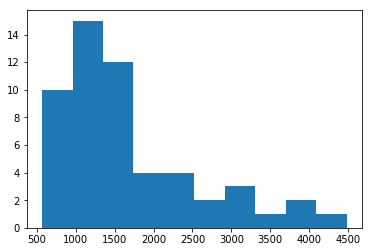

In [39]:
plt.hist(num_transac.transactions)

In [40]:
grocery_test = pd.merge(grocery_test, num_transac, how='left', on=['store_nbr'])

In [41]:
grocery_test.head()

,id,store_nbr,item_nbr,onpromotion,city,state,type,cluster,family,class,...,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start,Elapsed,ret_frq_by_store,ret_frq_by_item,total_store_sales,PayDay,transactions
0,125497040,1,96995,0,Quito,Pichincha,D,13,GROCERY I,1093,...,False,False,False,False,1502841600,84.0,0.0,3905175.25,1,1568.766324
1,125497041,1,99197,0,Quito,Pichincha,D,13,GROCERY I,1067,...,False,False,False,False,1502841600,84.0,0.0,3905175.25,1,1568.766324
2,125497042,1,103501,0,Quito,Pichincha,D,13,CLEANING,3008,...,False,False,False,False,1502841600,84.0,0.0,3905175.25,1,1568.766324
3,125497043,1,103520,0,Quito,Pichincha,D,13,GROCERY I,1028,...,False,False,False,False,1502841600,84.0,1.0,3905175.25,1,1568.766324
4,125497044,1,103665,0,Quito,Pichincha,D,13,BREAD/BAKERY,2712,...,False,False,False,False,1502841600,84.0,2.0,3905175.25,1,1568.766324


In [42]:
grocery_test.to_feather('grocery_test_final')

In [ ]:
def add_dum_col(df):
    df['dummy'] = 1
    df_new, _, _ = proc_df(df, 'dummy')
    return df_new

In [ ]:
grocery_test = add_dum_col(grocery_test)

# Machine Learning
## Split Training Set into Train + Validation Sets
We will use subsampling to avoid overfitting our data.  Let's set the validatation set to be all the data from `train_sub` starting from August 1, 2017 to the last day in the dataset, i.e. August 15 2017.

In [8]:
train_sub = pd.read_feather('grocery_train_raw_final')

In [10]:
train_sub.shape

(37454835, 34)

In [11]:
# Number of times every item in every store was returned
num_return = train_sub.groupby(by='store_nbr', as_index=False)['was_returned'].sum()

In [12]:
num_return.was_returned.unique()    # array([0, 1, 2, 3, 6, 4, 5])

array([  84.,   65.,  120.,   88.,   32.,   64.,   90.,   70.,   13.,   15.,   25.,   29.,   17.,   22.,
        135.,   24.,   37.,   42.,   19.,   57.,  114.,   55.,   20.,   50.,   26.,   38.,   36.,   27.,
         45.,  143.,   72.,  115.,   51.,   83.,    7.,   16.])

In [13]:
num_return = num_return.rename(columns = {'was_returned':'ret_frq_by_store'})

(array([ 12.,  15.,   9.,   4.,   5.,   3.,   1.,   2.,   1.,   2.]),
 array([   7. ,   20.6,   34.2,   47.8,   61.4,   75. ,   88.6,  102.2,  115.8,  129.4,  143. ]),
 <a list of 10 Patch objects>)

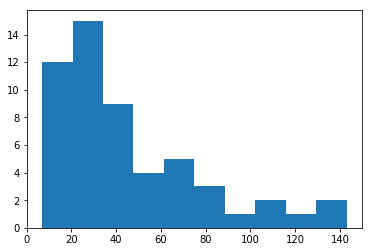

In [14]:
plt.hist(num_return.ret_frq_by_store)

In [15]:
train_sub = pd.merge(train_sub, num_return, how='left', on=['store_nbr'])

In [16]:
train_sub.head()

,id,store_nbr,item_nbr,unit_sales,onpromotion,was_returned,transactions,city,state,type,...,Dayofweek,Dayofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start,Elapsed,ret_frq_by_store
0,88106511,38,1998889,2.0,0,0,1301.0,Loja,Loja,D,...,0,228,False,False,False,False,False,False,1471219200,45.0
1,88106510,38,1998005,4.0,0,0,1301.0,Loja,Loja,D,...,0,228,False,False,False,False,False,False,1471219200,45.0
2,88106509,38,1997976,1.0,0,0,1301.0,Loja,Loja,D,...,0,228,False,False,False,False,False,False,1471219200,45.0
3,88106508,38,1997895,1.0,0,0,1301.0,Loja,Loja,D,...,0,228,False,False,False,False,False,False,1471219200,45.0
4,88106507,38,1994863,9.0,0,0,1301.0,Loja,Loja,D,...,0,228,False,False,False,False,False,False,1471219200,45.0


In [17]:
# Number of times every item in every store was returned
num_return_item = train_sub.groupby(by='item_nbr', as_index=False)['was_returned'].sum()

In [18]:
num_return_item.was_returned.unique()    # array([0, 1, 2, 3, 6, 4, 5])

array([ 0,  1,  2,  3, 18,  5,  4,  8,  6, 13, 19, 10, 46,  9, 12,  7, 22, 11, 65])

In [19]:
num_return_item = num_return_item.rename(columns = {'was_returned':'ret_frq_by_item'})

(array([ 4017.,    12.,     4.,     1.,     0.,     0.,     0.,     1.,     0.,     1.]),
 array([  0. ,   6.5,  13. ,  19.5,  26. ,  32.5,  39. ,  45.5,  52. ,  58.5,  65. ]),
 <a list of 10 Patch objects>)

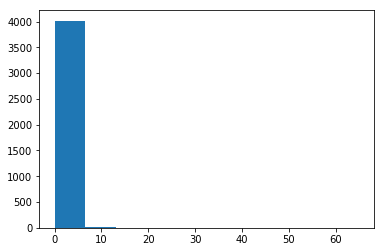

In [20]:
plt.hist(num_return_item.ret_frq_by_item)

In [22]:
train_sub = pd.merge(train_sub, num_return_item, how='left', on=['item_nbr'])

In [23]:
train_sub.head()

,id,store_nbr,item_nbr,unit_sales,onpromotion,was_returned,transactions,city,state,type,...,Dayofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start,Elapsed,ret_frq_by_store,ret_frq_by_item
0,88106511,38,1998889,2.0,0,0,1301.0,Loja,Loja,D,...,228,False,False,False,False,False,False,1471219200,45.0,1
1,88106510,38,1998005,4.0,0,0,1301.0,Loja,Loja,D,...,228,False,False,False,False,False,False,1471219200,45.0,0
2,88106509,38,1997976,1.0,0,0,1301.0,Loja,Loja,D,...,228,False,False,False,False,False,False,1471219200,45.0,2
3,88106508,38,1997895,1.0,0,0,1301.0,Loja,Loja,D,...,228,False,False,False,False,False,False,1471219200,45.0,0
4,88106507,38,1994863,9.0,0,0,1301.0,Loja,Loja,D,...,228,False,False,False,False,False,False,1471219200,45.0,0


In [24]:
train_sub.drop('was_returned', axis=1, inplace=True)

In [25]:
train_sub.head()

,id,store_nbr,item_nbr,unit_sales,onpromotion,transactions,city,state,type,cluster,...,Dayofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start,Elapsed,ret_frq_by_store,ret_frq_by_item
0,88106511,38,1998889,2.0,0,1301.0,Loja,Loja,D,4,...,228,False,False,False,False,False,False,1471219200,45.0,1
1,88106510,38,1998005,4.0,0,1301.0,Loja,Loja,D,4,...,228,False,False,False,False,False,False,1471219200,45.0,0
2,88106509,38,1997976,1.0,0,1301.0,Loja,Loja,D,4,...,228,False,False,False,False,False,False,1471219200,45.0,2
3,88106508,38,1997895,1.0,0,1301.0,Loja,Loja,D,4,...,228,False,False,False,False,False,False,1471219200,45.0,0
4,88106507,38,1994863,9.0,0,1301.0,Loja,Loja,D,4,...,228,False,False,False,False,False,False,1471219200,45.0,0


In [26]:
# For every store, add total number of sales
sales_by_store = train_sub.groupby(by=['store_nbr'], as_index=False)['unit_sales'].sum()
sales_by_store = sales_by_store.rename(columns = {'unit_sales':'total_store_sales'})
train_sub = pd.merge(train_sub, sales_by_store, how='left', on=['store_nbr'])

In [27]:
mid_month = train_sub.Dayofyear[train_sub.Day == 15].unique()
mid_month

end_month = train_sub.Dayofyear[train_sub.Is_month_end == True].unique()
end_month

paydates = np.append(mid_month, end_month)
paydates

#Adding pay days data to train_sub 
train_sub['PayDay'] = np.where(np.isin(train_sub.Dayofyear, paydates), 1, 0)

train_sub.Dayofyear[train_sub.PayDay == 1].unique()

array([228, 244, 259, 274, 289, 305, 320, 335, 350, 366,  15,  31,  46,  59,  74,  90, 105, 120, 135, 151,
       166, 181, 196, 212, 227])

In [28]:
train_sub.head()

,id,store_nbr,item_nbr,unit_sales,onpromotion,transactions,city,state,type,cluster,...,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start,Elapsed,ret_frq_by_store,ret_frq_by_item,total_store_sales,PayDay
0,88106511,38,1998889,2.0,0,1301.0,Loja,Loja,D,4,...,False,False,False,False,False,1471219200,45.0,1,4756712.5,1
1,88106510,38,1998005,4.0,0,1301.0,Loja,Loja,D,4,...,False,False,False,False,False,1471219200,45.0,0,4756712.5,1
2,88106509,38,1997976,1.0,0,1301.0,Loja,Loja,D,4,...,False,False,False,False,False,1471219200,45.0,2,4756712.5,1
3,88106508,38,1997895,1.0,0,1301.0,Loja,Loja,D,4,...,False,False,False,False,False,1471219200,45.0,0,4756712.5,1
4,88106507,38,1994863,9.0,0,1301.0,Loja,Loja,D,4,...,False,False,False,False,False,1471219200,45.0,0,4756712.5,1


In [24]:
random.seed(9001)

In [ ]:
def split_vals(a,n): return a[:n].copy(), a[n:].copy()

# Count the number of rows in the subset of train_sub containing Agu 2017 (15 days) data
n_valid = len(train_sub[(train_sub.Year == 2017) & (train_sub.Month == 8)])
n_trn = len(train_sub)-n_valid

In [28]:
train_sub.head().dtypes

id                             int32
store_nbr                       int8
item_nbr                       int32
unit_sales                   float32
onpromotion                     int8
transactions                 float64
city                        category
state                       category
type                        category
cluster                        int64
family                      category
class                          int64
perishable                     int64
dcoilwtico                   float32
holiday_type_city           category
description_city            category
holiday_type_state          category
description_state           category
holiday_type_nat            category
description_nat             category
Year                           int64
Month                          int64
Week                           int64
Day                            int64
Dayofweek                      int64
Dayofyear                      int64
Is_month_end                    bool
I

In [30]:
df_trn, y_trn, nas = proc_df(train_sub, 'unit_sales')

In [31]:
# Take log of unit_sales because log is used in the score (and it makes sense because otherwise we will penalize 
# deviations from the cost of more expensive item higher than cheaper items)
# Also, note that we need to use np.log1p because the score metric uses log(y + 1)_actual - log(y + 1)_pred
# So, our model must learn to minimize log(y + 1)_actual - log(y + 1)_pred
y_trn = np.log1p(np.clip(y_trn, 0, None))

In [32]:
X_train, X_valid = split_vals(df_trn, n_trn)
y_train, y_valid = split_vals(y_trn, n_trn)

In [33]:
# Compute arrays of item score weights for the items in the validation set (for which we will make predictions)
item_weight_train = 1 + X_train['perishable'] * 0.25
item_weight_valid = 1 + X_valid['perishable'] * 0.25

## Training the Random Forest

In [45]:
# This changes the RandomForestRegressor class attributes
# set_rf_samples(1_000_000)    # Probably needs to be reduced (by half or so)
reset_rf_samples()

In [46]:
# From JH's video (~29 min.) - optimizing the model fit by converting it to float array outside
# https://www.youtube.com/watch?v=YSFG_W8JxBo&feature=youtu.be
X_train= np.array(X_train, dtype=np.float32)
# Fitting the model 
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, n_jobs=-1, oob_score=True, verbose=1, max_features='sqrt')
%time m.fit(X_train, y_train)
# CPU times: user 37min 53s, sys: 4min 55s, total: 42min 49s
# Wall time: 15min 38s

[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:   44.1s finished


CPU times: user 2min 46s, sys: 4.89 s, total: 2min 51s
Wall time: 56.7 s


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='sqrt', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=3, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=40, n_jobs=-1,
           oob_score=True, random_state=None, verbose=1, warm_start=False)

In [47]:
# Save the trained model
from sklearn.externals import joblib
joblib.dump(m, 'rf_model_grocery_7.pkl')

['rf_model_grocery_7.pkl']

In [17]:
# Load the trained model
m = joblib.load('rf_model_grocery.pk1')

FileNotFoundError: [Errno 2] No such file or directory: 'rf_model_grocery.pk1'

## Scoring Metric for the Fitted Model

In [48]:
# Define NWRMSLE (scoring metric for the competition)
# Updated the metric since response variable is transformed now

# def nwrmsle(w,x,y): return math.sqrt(np.sum(np.dot(w,(np.log(x+1)-np.log(y+1))**2))/np.sum(w))

# Function below not needed now - already used np.clip
# Replacing returns (negative values) in predicted and actual repsonse variables with 0
# def returns_clean(y_val):
#     y_val[y_val < 0] = 0
#     return y_val

# Computes and returns NWRMSLE score and R-squared values
def get_score(model, X, y, weights):
    # Predicting for the input data
    y_hat = model.predict(X)
    # Calculating the residuals
    rsquared = model.score(X, y)
    # Specified score (from Kaggle)
    nwrmsle = math.sqrt(np.sum(np.multiply(weights, np.square(y_hat - y))) / np.sum(weights))
    res = [nwrmsle, rsquared]
    if hasattr(model, 'oob_score_'): res.append(model.oob_score_)
    return res

def combo_print_score(model, X_train, y_train, X_valid, y_valid, item_weight_train, item_weight_valid):
    print('For training set: (nwrmsle, rsquared)')
    print(get_score(model, X_train, y_train, item_weight_train))
    print('For validation set: (nwrmsle, rsquared)')
    print(get_score(model, X_valid, y_valid, item_weight_valid))

In [49]:
%time combo_print_score(m, X_train, y_train, X_valid, y_valid, item_weight_train, item_weight_valid)

For training set: (nwrmsle, rsquared)


[Parallel(n_jobs=4)]: Done  40 out of  40 | elapsed:    3.6s finished
[Parallel(n_jobs=4)]: Done  40 out of  40 | elapsed:    3.8s finished


[0.5656729624957131, 0.58119151769292543, 0.28522572156885773]
For validation set: (nwrmsle, rsquared)


[Parallel(n_jobs=4)]: Done  40 out of  40 | elapsed:    2.5s finished


[0.7277927346552904, 0.28786152518359931, 0.28522572156885773]
CPU times: user 50.7 s, sys: 2.09 s, total: 52.8 s
Wall time: 18.9 s


[Parallel(n_jobs=4)]: Done  40 out of  40 | elapsed:    2.5s finished


## Feature Importance

In [21]:
fi = rf_feat_importance(m, df_trn); fi[:10]

,cols,imp
2,item_nbr,0.277675
5,transactions,0.165974
11,class,0.151494
10,family,0.055230
23,Day,0.044355
13,dcoilwtico,0.040173
1,store_nbr,0.039665
0,id,0.037631
24,Dayofweek,0.028694
25,Dayofyear,0.026660


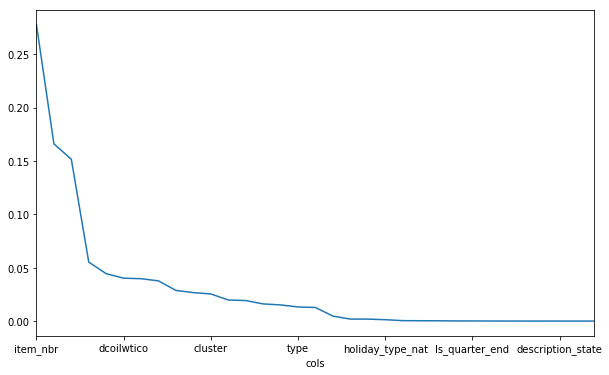

In [22]:
fi.plot('cols', 'imp', figsize=(10,6), legend=False);

In [23]:
def plot_fi(fi): return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

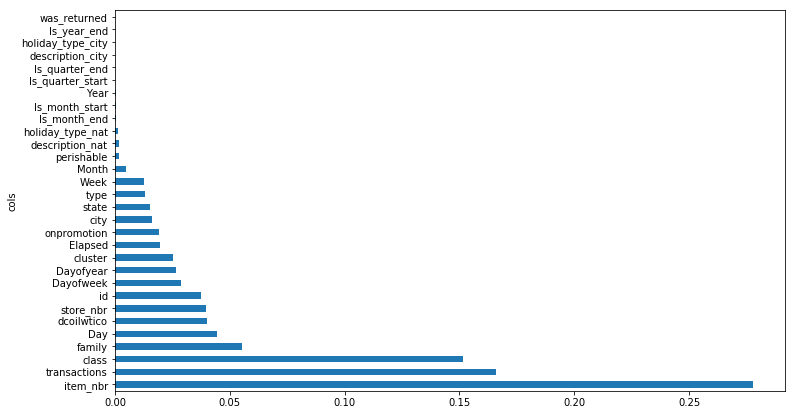

In [24]:
plot_fi(fi[:30]);

In [99]:
to_keep = fi[fi.imp>0.005].cols; len(to_keep)

17

# Test Data and Predictions
## Imputing Transactions Data
### Split Training Set into Train + Validation Sets

In [ ]:
# df_trn was generated earlier - we use that and drop some columns to form the X matrix for imputing trasnsactions
df_transac_trn, y_transac_trn, _ = proc_df(df_trn, 'transactions')

In [85]:
def display_all(df):
   with pd.option_context("display.max_rows", 1000):
       with pd.option_context("display.max_columns", 1000):
           display(df)
display_all(df_transac_trn.tail().transpose())

,37454830,37454831,37454832,37454833,37454834
id,125428492,125428491,125428490,125428500,125497039
store_nbr,19,19,19,19,54
item_nbr,870546,870545,870544,875604,2116416
onpromotion,0,0,0,0,0
city,8,8,8,8,6
state,2,2,2,2,11
type,3,3,3,3,3
cluster,15,15,15,15,3
family,26,26,26,13,13
class,4126,4126,4126,1026,1060


In [18]:
X_transac_train, X_transac_valid = split_vals(df_transac_trn, n_trn)
y_transac_train, y_transac_valid = split_vals(y_transac_trn, n_trn)

### Training the Random Forest

In [19]:
# This changes the RandomForestRegressor class attributes
set_rf_samples(1_000_000)    # Probably needs to be reduced (by half or so)

In [20]:
# From JH's video (~29 min.) - optimizing the model fit by converting it to float array outside
# https://www.youtube.com/watch?v=YSFG_W8JxBo&feature=youtu.be
X_transac_train= np.array(X_transac_train, dtype=np.float32)
# Fitting the model 
m_transac = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, n_jobs=-1, oob_score=False, verbose=1)
%time m_transac.fit(X_transac_train, y_transac_train)
# CPU times: user 19min 27s, sys: 2min 27s, total: 21min 55s
# Wall time: 6min 56s

CPU times: user 19min 27s, sys: 2min 27s, total: 21min 55s
Wall time: 6min 56s


[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:  6.9min finished


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=3, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=40, n_jobs=-1,
           oob_score=False, random_state=None, verbose=1, warm_start=False)

In [22]:
# Save the trained model
from sklearn.externals import joblib
joblib.dump(m_transac, 'rf_model_grocery_transac.pkl')

['rf_model_grocery_transac.pkl']

In [17]:
# Load the trained model
m_transac = joblib.load('rf_model_grocery_transac.pk1')

FileNotFoundError: [Errno 2] No such file or directory: 'rf_model_grocery.pk1'

In [25]:
# Computes and returns NWRMSLE score and R-squared values
def get_score_transac(model, X, y):
    # Predicting for the input data
    y_hat = model.predict(X)
    # Calculating the residuals
    rsquared = model.score(X, y)
    return rsquared

def combo_print_score_transac(model, X_train, y_train, X_valid, y_valid):
    print('For training set: (rsquared)')
    print(get_score_transac(model, X_train, y_train))
    print('For validation set: (rsquared)')
    print(get_score_transac(model, X_valid, y_valid))

In [26]:
combo_print_score_transac(m_transac, X_transac_train, y_transac_train, X_transac_valid, y_transac_valid)

For training set: (rsquared)


[Parallel(n_jobs=4)]: Done  40 out of  40 | elapsed:   45.0s finished
[Parallel(n_jobs=4)]: Done  40 out of  40 | elapsed:   44.3s finished


0.999998027319
For validation set: (rsquared)


[Parallel(n_jobs=4)]: Done  40 out of  40 | elapsed:    1.4s finished


0.966038069366


[Parallel(n_jobs=4)]: Done  40 out of  40 | elapsed:    1.4s finished


In [94]:
def add_dum_col(df):
    df['dummy'] = 1
    df_new, _, _ = proc_df(df, 'dummy')
    return df_new

In [95]:
#Numericalize grocery_test dataframe
grocery_test = add_dum_col(grocery_test)

In [96]:
pred_transac_test = m_transac.predict(grocery_test)

[Parallel(n_jobs=4)]: Done  40 out of  40 | elapsed:    2.3s finished


In [100]:
grocery_test['transactions'] = pred_transac_test

TypeError: only length-1 arrays can be converted to Python scalars

In [101]:
grocery_test.transactions = grocery_test.transactions.astype('int16')

In [103]:
grocery_test.transactions.describe()

count    3.370464e+06
mean     1.876478e+03
std      1.034257e+03
min      4.640000e+02
25%      1.069750e+03
50%      1.751000e+03
75%      2.075000e+03
max      6.398000e+03
Name: transactions, dtype: float64

In [104]:
train_sub.transactions.describe()

count    3.745484e+07
mean     1.868045e+03
std      1.049707e+03
min      5.000000e+00
25%      1.146000e+03
50%      1.520000e+03
75%      2.314000e+03
max      8.307000e+03
Name: transactions, dtype: float64

In [105]:
train_sub[(train_sub.Year == 2016) & (train_sub.Month == 8)].transactions.describe()

count    1.614572e+06
mean     1.760744e+03
std      9.369349e+02
min      4.200000e+02
25%      1.098000e+03
50%      1.438000e+03
75%      2.266000e+03
max      4.830000e+03
Name: transactions, dtype: float64

## Predicting for Test Set

In [112]:
!ls

GrocerySales_03.ipynb          fromKernel.ipynb
GrocerySales_03_AA.ipynb       median_ma8.csv.gz
GrocerySales_03_old.ipynb      rf_model_grocery_1.pkl
GrocerySales_03_old2.ipynb     rf_model_grocery_2.pkl
GrocerySales_04.ipynb          rf_model_grocery_3.pkl
GrocerySales_AA_02.ipynb       rf_model_grocery_4.pkl
GrocerySales_KK_01.ipynb       rf_model_grocery_5.pkl
GrocerySales_KK_02.ipynb       rf_model_grocery_6.pkl
Grocery_Sales_Anant.ipynb      rf_model_grocery_7_fi.pkl
Notes.docx                     rf_model_grocery_transac.pkl
README.md                      tmp
basedOnKernelmedian_ma6.csv    track_models.csv
basedOnKernelmedian_ma6.csv.gz train.csv
fastai


In [117]:
# If you have a saved model, load here:
m = joblib.load('/Users/kunal/Desktop/MSAN_Coursework/621_ML/Kaggle/Kaggle_Grocery_Sales_Forecast/rf_model_grocery_6.pk1')

FileNotFoundError: [Errno 2] No such file or directory: '/Users/kunal/Desktop/MSAN_Coursework/621_ML/Kaggle/Kaggle_Grocery_Sales_Forecast/rf_model_grocery_6.pk1'

In [139]:
%time pred_test_log = m.predict(grocery_test)

CPU times: user 12.9 s, sys: 2.51 s, total: 15.4 s
Wall time: 9.92 s


[Parallel(n_jobs=4)]: Done  40 out of  40 | elapsed:    2.6s finished


In [158]:
pred_test = np.round(np.expm1(pred_test_log), decimals=0)

In [159]:
output = pd.concat([grocery_test['id'],pd.DataFrame(pred_test)],axis=1)

In [160]:
#Changing column names
output.columns = ['id','unit_sales']

In [161]:
output.head()

,id,unit_sales
0,125497040,8.0
1,125497041,8.0
2,125497042,8.0
3,125497043,8.0
4,125497044,8.0


In [162]:
output.to_csv('predicted.csv',index=False)

In [163]:
output.unit_sales.describe()

count    3.370464e+06
mean     4.893297e+00
std      2.226395e+00
min      1.000000e+00
25%      3.000000e+00
50%      5.000000e+00
75%      7.000000e+00
max      9.000000e+00
Name: unit_sales, dtype: float64